Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
from utils import *
from classes import *
from train_utils import train

use_gpu = torch.cuda.is_available()

print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
jqnet1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = jqnet1_data_transforms


Set up data transforms.


In [3]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================


print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])


print('Using default ImageFolder dataset.')
book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                transform = data_transforms[t])#, transform=test_transform)
                      for t in set_types}
                 for b in books_in_data}


print('Counting images')
no_transform_datasets = {b : datasets.ImageFolder(os.path.join(book_data_dir, b)) for b in books_in_data}
image_counts = {book : {0 : 0, 1 : 0} for book in no_transform_datasets}
for book in no_transform_datasets:
    for im, target in no_transform_datasets[book]:
        image_counts[book][target] += 1
        
print(image_counts)

print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
Counting images
{'Voltaire': {0: 55, 1: 305}, 'Confucius': {0: 6, 1: 165}, 'Dryden': {0: 39, 1: 9}, 'Blackmore': {0: 36, 1: 292}, 'Defoe': {0: 107, 1: 229}, 'Albin': {0: 143, 1: 31}, 'Allestree': {0: 66, 1: 212}, 'Browne': {0: 160, 1: 200}, 'Ascham': {0: 20, 1: 76}, 'Montaigne': {0: 129, 1: 538}}
data loading complete


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [5]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


use_gpu is True
validating on book: 'Voltaire'
Creating JQ's net1.
train counts {0: 706, 1: 1752}

Epoch 0/1
----------
Phase:train
average loss: 0.6974491704178669
f1_pos: 0.6876310272536688
f1_neg: 0.34505494505494505

Phase:val
average loss: 0.638857920964559
f1_pos: 0.9172932330827067
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.694685831866931
f1_pos: 0.76059618071728
f1_neg: 0.23397913561847988

Phase:val
average loss: 0.6460261742273966
f1_pos: 0.9172932330827067
f1_neg: 0

Training complete in 0m 24s


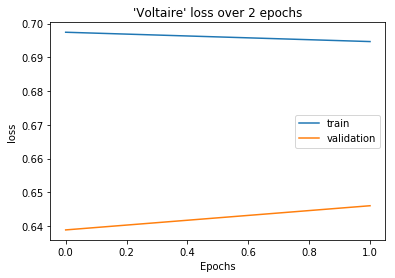

Average Training Score: 0.6960675011423989
Average Validation Score: 0.6424420475959778


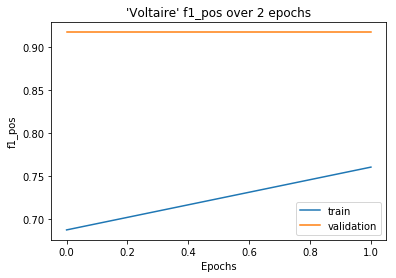

Average Training Score: 0.7241136039854743
Average Validation Score: 0.9172932330827067


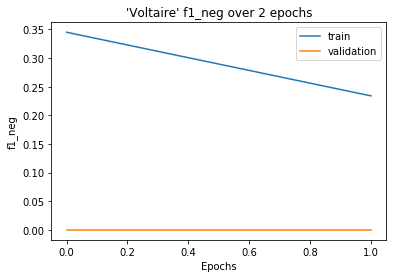

Average Training Score: 0.28951704033671244
Average Validation Score: 0.0
Wrote metrics to 'raw_logs/Voltaire.csv'

validating on book: 'Confucius'
Creating JQ's net1.
train counts {0: 755, 1: 1892}

Epoch 0/1
----------
Phase:train
average loss: 0.6984361902122552
f1_pos: 0.7550391273417121
f1_neg: 0.27202255109231854

Phase:val
average loss: 0.6459473061282732
f1_pos: 0.9760479041916168
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6858123559914556
f1_pos: 0.732897384305835
f1_neg: 0.36024096385542165

Phase:val
average loss: 0.6173126380345975
f1_pos: 0.9760479041916168
f1_neg: 0

Training complete in 0m 22s


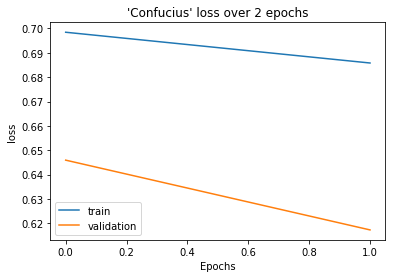

Average Training Score: 0.6921242731018554
Average Validation Score: 0.6316299720814353


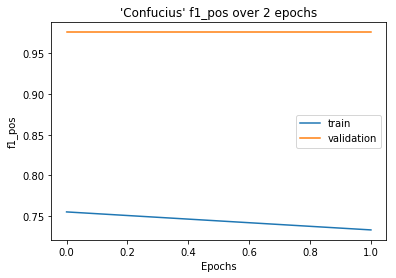

Average Training Score: 0.7439682558237735
Average Validation Score: 0.9760479041916168


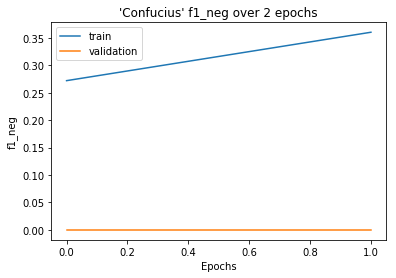

Average Training Score: 0.3161317574738701
Average Validation Score: 0.0
Wrote metrics to 'raw_logs/Confucius.csv'

validating on book: 'Dryden'
Creating JQ's net1.
train counts {0: 722, 1: 2048}

Epoch 0/1
----------
Phase:train
average loss: 0.7067983238895029
f1_pos: 0.6480173818576861
f1_neg: 0.33674513817809626

Phase:val
average loss: 0.6743272542953491
f1_pos: 0
f1_neg: 0.896551724137931


Epoch 1/1
----------
Phase:train
average loss: 0.6927182644795999
f1_pos: 0.3328313253012048
f1_neg: 0.4053691275167785

Phase:val
average loss: 0.6759725213050842
f1_pos: 0
f1_neg: 0.8433734939759037

Training complete in 0m 22s


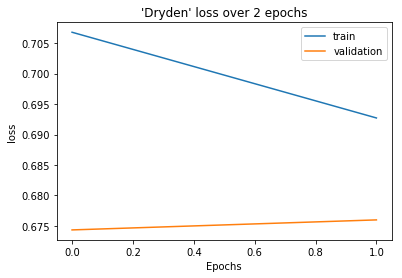

Average Training Score: 0.6997582941845515
Average Validation Score: 0.6751498878002167


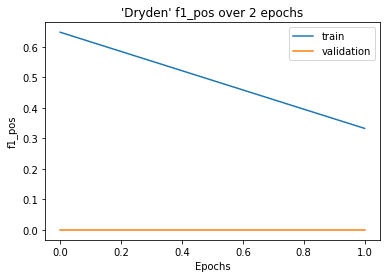

Average Training Score: 0.49042435357944547
Average Validation Score: 0.0


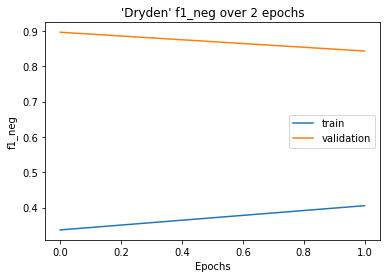

Average Training Score: 0.37105713284743735
Average Validation Score: 0.8699626090569174
Wrote metrics to 'raw_logs/Dryden.csv'

validating on book: 'Blackmore'
Creating JQ's net1.
train counts {0: 725, 1: 1765}

Epoch 0/1
----------
Phase:train
average loss: 0.6964784943101421
f1_pos: 0.6595744680851064
f1_neg: 0.366497461928934

Phase:val
average loss: 0.6624631071236076
f1_pos: 0.9489291598023064
f1_neg: 0.3673469387755102


Epoch 1/1
----------
Phase:train
average loss: 0.689792192219165
f1_pos: 0.7215909090909092
f1_neg: 0.3888888888888889

Phase:val
average loss: 0.6984523396666457
f1_pos: 0.20238095238095238
f1_neg: 0.1625

Training complete in 0m 24s


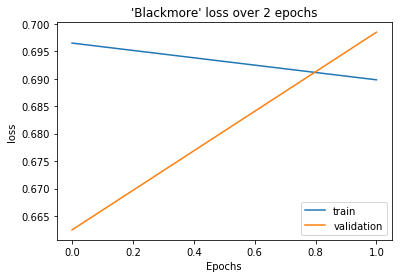

Average Training Score: 0.6931353432646535
Average Validation Score: 0.6804577233951266


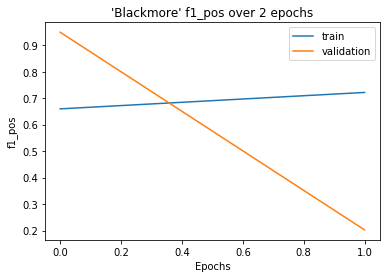

Average Training Score: 0.6905826885880078
Average Validation Score: 0.5756550560916294


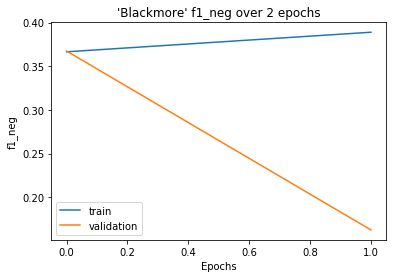

Average Training Score: 0.37769317540891145
Average Validation Score: 0.26492346938775513
Wrote metrics to 'raw_logs/Blackmore.csv'

validating on book: 'Defoe'
Creating JQ's net1.
train counts {0: 654, 1: 1828}

Epoch 0/1
----------
Phase:train
average loss: 0.6983111954649092
f1_pos: 0.722290188402251
f1_neg: 0.26726920593931563

Phase:val
average loss: 0.6974261796900204
f1_pos: 0.8106194690265487
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6887243873181286
f1_pos: 0.6905384213277574
f1_neg: 0.34585635359116024

Phase:val
average loss: 0.6968728768683615
f1_pos: 0.8121645796064401
f1_neg: 0.07079646017699114

Training complete in 0m 24s


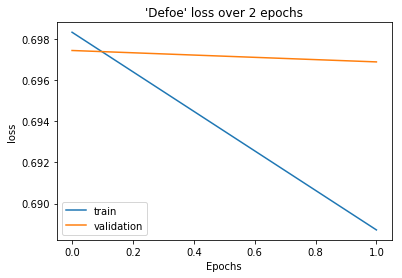

Average Training Score: 0.6935177913915189
Average Validation Score: 0.697149528279191


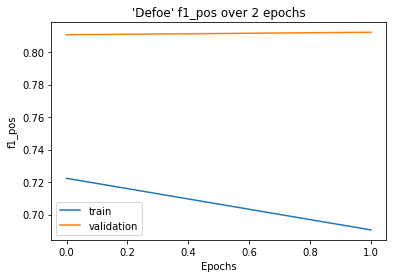

Average Training Score: 0.7064143048650042
Average Validation Score: 0.8113920243164944


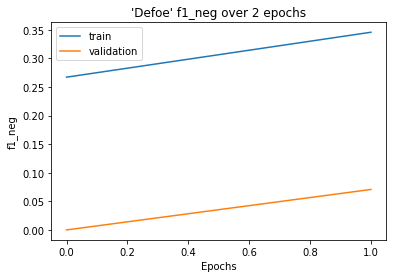

Average Training Score: 0.30656277976523794
Average Validation Score: 0.03539823008849557
Wrote metrics to 'raw_logs/Defoe.csv'

validating on book: 'Albin'
Creating JQ's net1.
train counts {0: 618, 1: 2026}

Epoch 0/1
----------
Phase:train
average loss: 0.7032460249257139
f1_pos: 0.2987164527421237
f1_neg: 0.4117455138662317

Phase:val
average loss: 0.6474244443849585
f1_pos: 0
f1_neg: 0.9022082018927445


Epoch 1/1
----------
Phase:train
average loss: 0.6880009016557481
f1_pos: 0.26216324889425013
f1_neg: 0.4172753255001588

Phase:val
average loss: 0.6105362080979622
f1_pos: 0
f1_neg: 0.9022082018927445

Training complete in 0m 22s


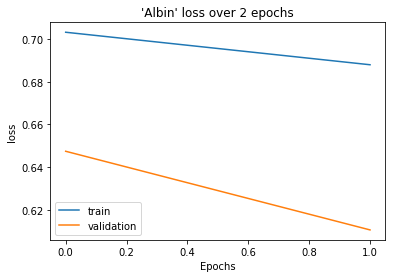

Average Training Score: 0.695623463290731
Average Validation Score: 0.6289803262414604


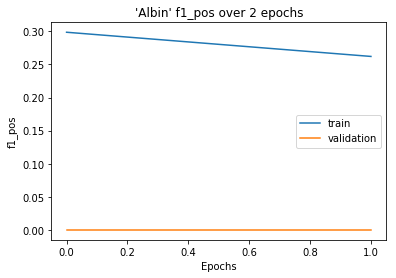

Average Training Score: 0.2804398508181869
Average Validation Score: 0.0


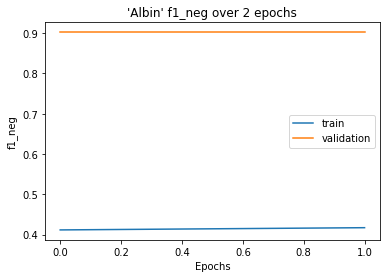

Average Training Score: 0.41451041968319524
Average Validation Score: 0.9022082018927445
Wrote metrics to 'raw_logs/Albin.csv'

validating on book: 'Allestree'
Creating JQ's net1.
train counts {0: 695, 1: 1845}

Epoch 0/1
----------
Phase:train
average loss: 0.7002627919378477
f1_pos: 0.5775528431080679
f1_neg: 0.3768115942028986

Phase:val
average loss: 0.680866786473089
f1_pos: 0.3565891472868217
f1_neg: 0.44295302013422816


Epoch 1/1
----------
Phase:train
average loss: 0.6890226739615393
f1_pos: 0.6558190843905131
f1_neg: 0.3791044776119402

Phase:val
average loss: 0.6606881631364068
f1_pos: 0.9666666666666666
f1_neg: 0.8970588235294117

Training complete in 0m 23s


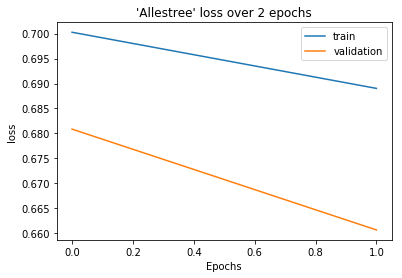

Average Training Score: 0.6946427329496935
Average Validation Score: 0.6707774748047479


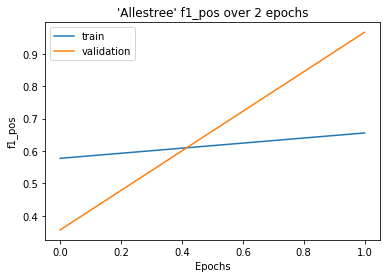

Average Training Score: 0.6166859637492905
Average Validation Score: 0.6616279069767441


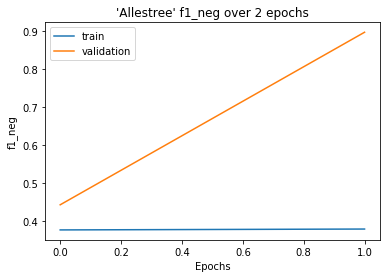

Average Training Score: 0.3779580359074194
Average Validation Score: 0.67000592183182
Wrote metrics to 'raw_logs/Allestree.csv'

validating on book: 'Browne'
Creating JQ's net1.
train counts {0: 601, 1: 1857}

Epoch 0/1
----------
Phase:train
average loss: 0.7016307381216391
f1_pos: 0.47479131886477455
f1_neg: 0.4043922756531617

Phase:val
average loss: 0.6703406986263063
f1_pos: 0
f1_neg: 0.6153846153846153


Epoch 1/1
----------
Phase:train
average loss: 0.692448922469313
f1_pos: 0.4082650516565729
f1_neg: 0.4128667373630258

Phase:val
average loss: 0.6673185759120517
f1_pos: 0
f1_neg: 0.6153846153846153

Training complete in 0m 24s


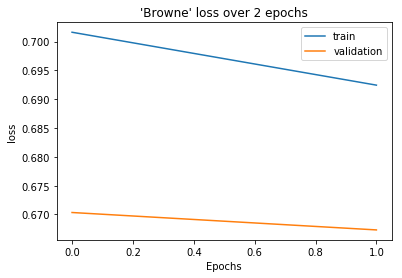

Average Training Score: 0.6970398302954761
Average Validation Score: 0.668829637269179


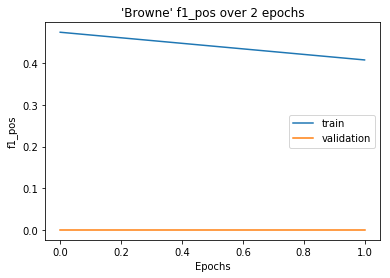

Average Training Score: 0.4415281852606737
Average Validation Score: 0.0


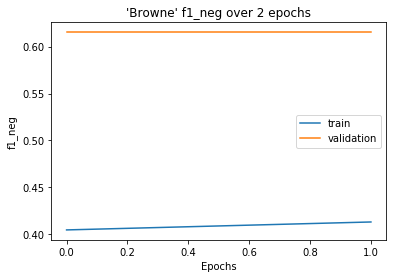

Average Training Score: 0.40862950650809376
Average Validation Score: 0.6153846153846153
Wrote metrics to 'raw_logs/Browne.csv'

validating on book: 'Ascham'
Creating JQ's net1.
train counts {0: 741, 1: 1981}

Epoch 0/1
----------
Phase:train
average loss: 0.7039669625635601
f1_pos: 0.730228044638525
f1_neg: 0.2655217965653897

Phase:val
average loss: 0.6730112309257189
f1_pos: 0.9599999999999999
f1_neg: 0.8571428571428572


Epoch 1/1
----------
Phase:train
average loss: 0.6931652731299823
f1_pos: 0.7790279027902791
f1_neg: 0.17617449664429527

Phase:val
average loss: 0.6738512093822161
f1_pos: 0.8837209302325582
f1_neg: 0

Training complete in 0m 22s


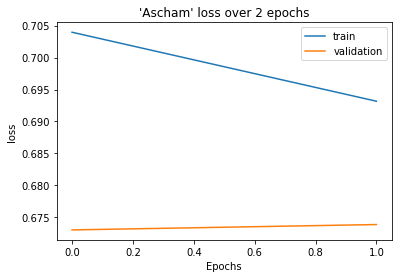

Average Training Score: 0.6985661178467713
Average Validation Score: 0.6734312201539675


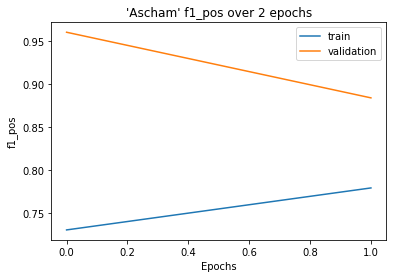

Average Training Score: 0.754627973714402
Average Validation Score: 0.921860465116279


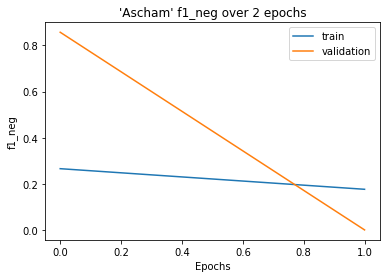

Average Training Score: 0.22084814660484248
Average Validation Score: 0.4285714285714286
Wrote metrics to 'raw_logs/Ascham.csv'

validating on book: 'Montaigne'
Creating JQ's net1.
train counts {0: 632, 1: 1519}

Epoch 0/1
----------
Phase:train
average loss: 0.6989039847662976
f1_pos: 0.7851183765501691
f1_neg: 0.20649458784346378

Phase:val
average loss: 0.6711259484291077
f1_pos: 0.8929460580912862
f1_neg: 0


Epoch 1/1
----------
Phase:train
average loss: 0.6852338356782224
f1_pos: 0.8249946317371698
f1_neg: 0.16751787538304394

Phase:val
average loss: 0.6847888166042997
f1_pos: 0.8962025316455695
f1_neg: 0.174496644295302

Training complete in 0m 27s


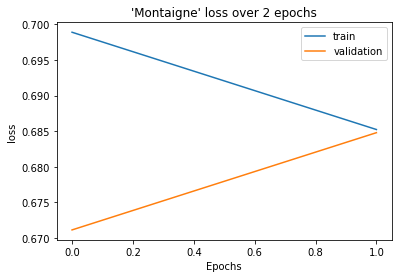

Average Training Score: 0.6920689102222599
Average Validation Score: 0.6779573825167037


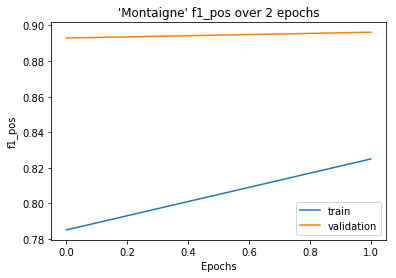

Average Training Score: 0.8050565041436695
Average Validation Score: 0.8945742948684279


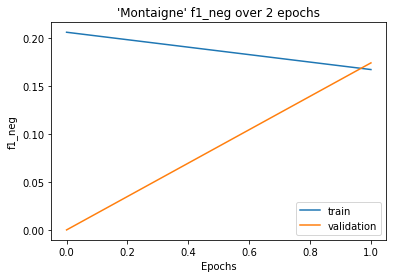

Average Training Score: 0.18700623161325386
Average Validation Score: 0.087248322147651
Wrote metrics to 'raw_logs/Montaigne.csv'

training complete


In [6]:
# ========================================
# Step 5. execute the train process
# ========================================

from train_utils import train

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))
device_name = 'cuda' if use_gpu else 'cpu'

batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {book : {metric : [] for metric in metric_names_all} for book in books_in_data}

# train parameters
num_training_epochs = 2
# num_training_epochs = 100

# leave-one-book-out cross validation
for val_book in books_in_data:
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([book_data_sets[b]['train'] for b in book_data_sets]),
        batch_size=batch_size,
        shuffle=True, # make sure you shuffle the data
        num_workers=4)
    val_loader = torch.utils.data.DataLoader(book_data_sets[val_book]['val'],
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 4)
    
    # get the model architecture
    model = create_model_architecture('jq_net1')
    
    # model hyperparameters
    
    # check weights added to CrossEntropyLoss [1, 1/(#pos in train / #neg in train)]
    train_counts = {c : sum([image_counts[b][c] for b in train_books]) for c in [0,1]}
    print('train counts', train_counts)
    loss_weights = torch.FloatTensor([1, float(train_counts[0])/float(train_counts[1])])
    loss_weights = loss_weights.to(device_name)
    
    criterion = nn.CrossEntropyLoss(weight = loss_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # train
    trained_model, train_metrics = train(model,
                                         criterion,
                                         optimizer,
                                         train_loader,
                                         val_loader,
                                         num_epochs=num_training_epochs,
                                         use_gpu = use_gpu)
    
    # update metrics dicts
    all_metrics[str(val_book)] = train_metrics
    
    # plot all metrics
    for metric in metric_types_plot:
        plot_values(all_metrics[str(val_book)]['train-' + str(metric)],
                   all_metrics[str(val_book)]['val-' + str(metric)],
                   "'" + str(val_book) + "' " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
        
    # write metrics to file
    write_metrics_to_csv(all_metrics[str(val_book)], metric_names_all, 'raw_logs', str(val_book) + '.csv')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

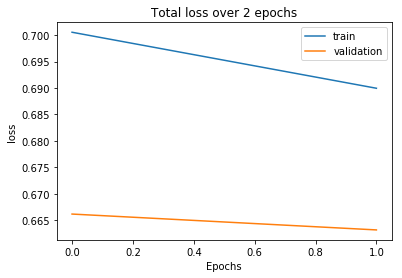

Average Training Score: 0.695254425768991
Average Validation Score: 0.6646805200138006


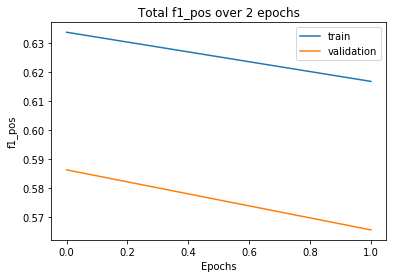

Average Training Score: 0.6253841684527928
Average Validation Score: 0.5758450884643898


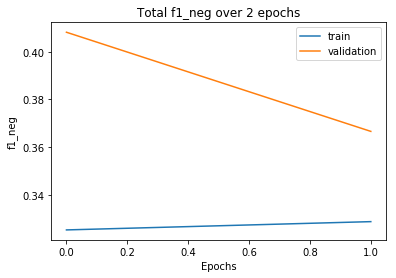

Average Training Score: 0.32699142261489744
Average Validation Score: 0.38737027983614275


In [7]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_metrics = {metric : [np.mean([all_metrics[book][metric][epoch] for book in all_metrics])
                           for epoch in range(num_training_epochs)]
                 for metric in metric_names_plot}

for metric in metric_types_plot:
    plot_values(total_metrics['train-' + str(metric)],
                   total_metrics['val-' + str(metric)],
                   "Total " + str(metric) + " over " + str(num_training_epochs) + " epochs",
                   ylabel = str(metric))
